# Results from Google Big Query: HackerNews
## https://github.com/HackerNews/API for fields definition

## Aim: What are the top 10 frequently used words to get a high score in HackerNews

In [87]:
import pandas as pd
import numpy as np

df = pd.read_csv('/Users/jing/Desktop/GA/Project_GA/hn_story.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
by             10000 non-null object
score          10000 non-null int64
time           10000 non-null int64
title          10000 non-null object
type           10000 non-null object
url            279 non-null object
text           10000 non-null object
parent         0 non-null float64
deleted        0 non-null float64
dead           1849 non-null object
descendants    8151 non-null float64
id             10000 non-null int64
ranking        0 non-null float64
dtypes: float64(4), int64(3), object(6)
memory usage: 1015.7+ KB


# Cleaning of Data

In [88]:
#deleted, ranking are all null. drop those columns.
df.drop(['deleted', 'ranking'], axis=1,inplace = True)

#parent's ids are irrelevant to predict scores
df.drop(['parent'], axis = 1, inplace = True)

#time is in unix, change it to mm/dd/yy hh:mm:ss 
df=df.set_index(pd.to_datetime(df['time'], unit='s'))
df.index.rename('GMT_time', inplace=True)

#dead is boolean. those null = False. transform it to 1 and 0
df['dead'].fillna(value=False, inplace  = True)
df[['dead']]=df[['dead']].astype(int)

#assume descendants null = 0
df['descendants'].fillna(value =0, inplace =True)

#add len of text to part of df
df['text_length'] = df['text'].str.len()
#creating column for hour when story is posted
df['post_hour'] = pd.DatetimeIndex(df.index).hour
df['post_hour'].fillna(value = df['post_hour'].mean(), inplace = True)
df['post_day'] = pd.DatetimeIndex(df.index).dayofweek #0 for monday
df['post_day'].fillna(value = df['post_day'].mean(), inplace = True)

# Visualisation

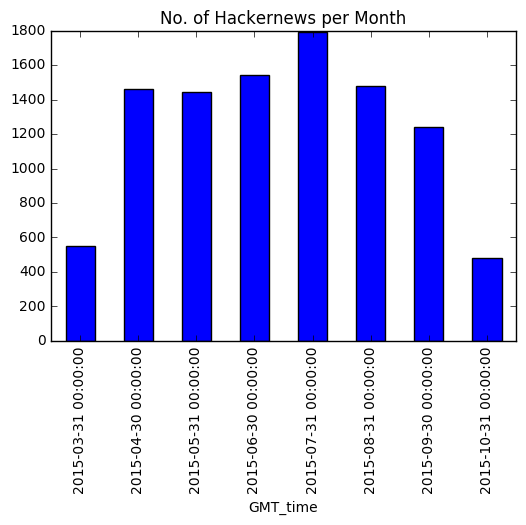

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt

#which W has the most hackernews 
bar_chart=df['id'].groupby(pd.TimeGrouper("M")).count().plot(kind='bar', title='No. of Hackernews per Month')
bar_chart.x_label = 'Date'
bar_chart.y_label = 'Quantity'

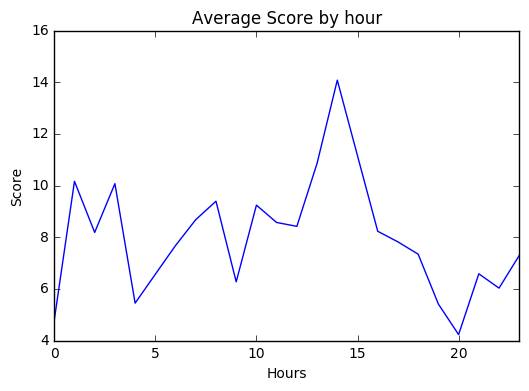

In [123]:
#which hour have the most post 
hour_chart = df['score'].groupby(df['post_hour']).mean().plot(kind ='line', title ='Average Score by hour')
hour_chart.set_xlabel('Hours')
hour_chart.set_ylabel('Score')

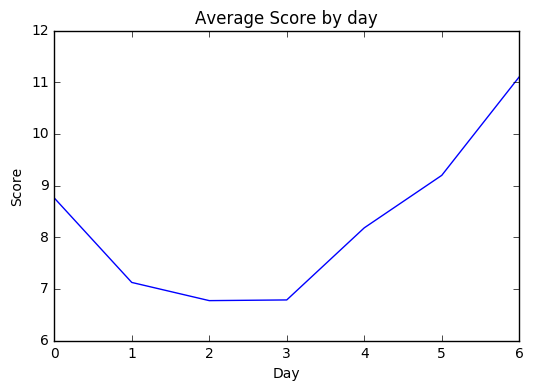

In [124]:
#which day have the most post 
day_chart = df['score'].groupby(df['post_day']).mean().plot(kind ='line', title ='Average Score by day')
day_chart.set_xlabel('Day') #0 is monday
day_chart.set_ylabel('Score')

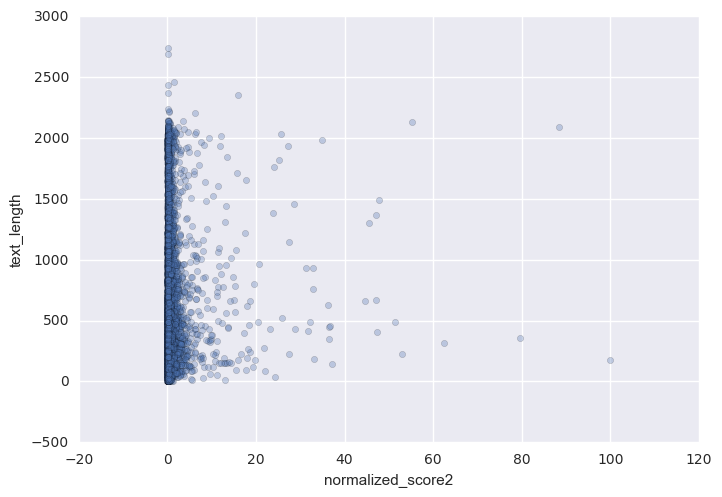

In [160]:
df.plot.scatter(x = 'normalized_score2', y ='text_length',alpha =0.3)

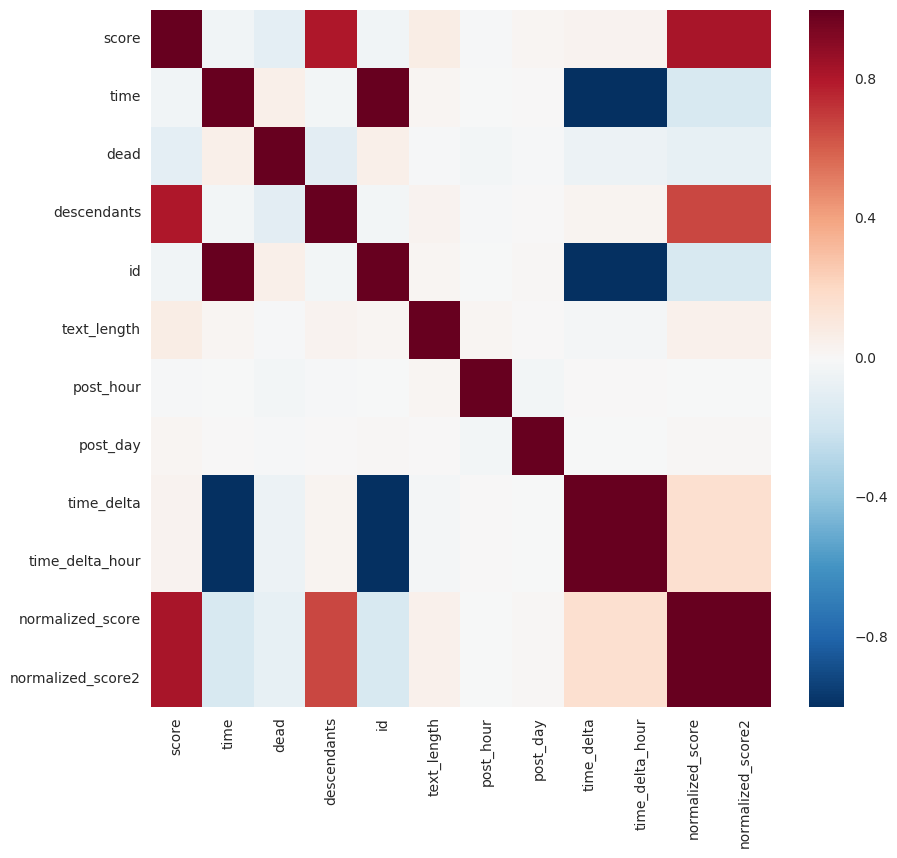

In [130]:
import seaborn as sns
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(df.corr())

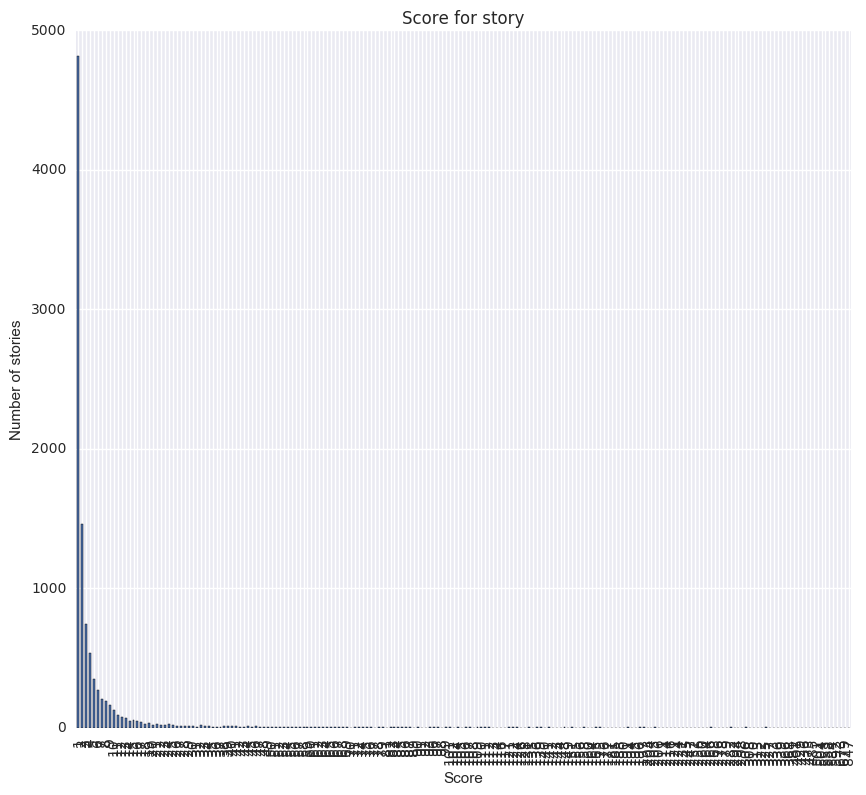

In [143]:
#groupby scores and count stories. check what is the most common score for a story
f, ax = plt.subplots(figsize=(10, 9))
score_chart = df['id'].groupby(df['score']).count().plot(kind ='bar',title='Score for story')
score_chart.set_xlabel('Score')
score_chart.set_ylabel('Number of stories')

## Need to normalise the score. Thanks Guojun!

## Normalize the Score base on:
### https://medium.com/hacking-and-gonzo/how-hacker-news-ranking-algorithm-works-1d9b0cf2c08d#.xea611fdv
### Score = (P-1) / (T+2)^G 
<p>where
<br>P = points of an item (and -1 is to negate submitters vote)
<br>T = time since submission (in hours)
<br>G = Gravity, defaults to 1.8 in news.arc

In [89]:
df['time_delta'] = df['time'].max() - df['time']
#group the time_delta column to the nearest hour since the algo uses the nearest hour
df['time_delta_hour'] = df['time_delta']/3600 
df['time_delta_hour'] = df['time_delta_hour'].apply(np.floor).astype(int)

def calculate_reverse_score(score, time_delta_hour, gravity=1.8):
    #Return normalize score
    #Dangerous numbers too big
    return (score * pow((time_delta_hour+2), gravity) + 1)

df['normalized_score'] = np.vectorize(calculate_reverse_score)(df['score'], df['time_delta_hour'])

#normalized: 0 to 100
df['normalized_score2'] = ((df['normalized_score'] - df['normalized_score'].min())/df['normalized_score'].max()) * 100

#To see top 50 
df.sort_values(by='normalized_score2', ascending=False).head(50)

,by,score,time,title,type,url,text,dead,descendants,id,text_length,post_hour,post_day,time_delta,time_delta_hour,normalized_score,normalized_score2
GMT_time,,,,,,,,,,,,,,,,,
2015-04-01 06:49:10,conroy,592,1427870950,List of April Fools' Day Announcements,story,NaN,Instead of cluttering the front page with fake...,0,538.0,9302010,180,6,2,16848487,4680,2.393857e+09,100.000000
2015-04-07 23:29:10,tastyface,558,1428449350,Ask HN: How do you deal with professional jeal...,story,NaN,I&#x27;m a 26 y.o. software dev working on goi...,0,408.0,9337863,2091,23,1,16270087,4519,2.118636e+09,88.503015
2015-04-01 13:38:36,_whoishiring,473,1427895516,Ask HN: Who is hiring? (April 2015),story,NaN,Please lead with the location of the position ...,0,952.0,9303396,354,13,2,16823921,4673,1.907515e+09,79.683757
2015-05-01 14:03:14,_whoishiring,501,1430488994,Ask HN: Who is hiring? (May 2015),story,NaN,\tPlease lead with the location of the positio...,0,895.0,9471287,314,14,4,14230443,3952,1.494527e+09,62.431746
2015-03-30 13:58:07,ryannevius,322,1427723887,Ask HN: How to move beyond “freelancer”?,story,NaN,I&#x27;ve been doing freelance web development...,0,123.0,9289500,2133,13,0,16995550,4720,1.322156e+09,55.231189
2015-03-26 17:53:33,mdlm,298,1427392413,Tell Sam Altman: I will take your bet,story,NaN,"Sam,<p>I will take your bet.<p>I run a VC fund...",0,127.0,9271679,225,17,3,17327024,4813,1.267330e+09,52.940903
2015-03-23 16:02:21,pvinis,282,1427126541,Ask HN: Does anyone else value the comments mo...,story,NaN,I always open the comment page of a HN post fi...,0,96.0,9251577,486,16,0,17592896,4886,1.232212e+09,51.473893
2015-05-31 21:07:54,dang,553,1433106474,"Tell HN: Thank you whoishiring, a.k.a. Matthew...",story,NaN,"Back in 2011, an HN user volunteered to consol...",0,133.0,9635551,1492,21,6,11612963,3225,1.144362e+09,47.804087
2015-05-22 15:32:05,bluedevil2k,485,1432308725,Ask HN: Where can I buy real software companies?,story,NaN,So I have a software company that is generatin...,0,158.0,9588901,410,15,4,12410712,3447,1.131330e+09,47.259731


# Remove stop word and strange characters from text

In [106]:
import re

#need to remove entire word with weird character....
df['text_nourl'] = df['text'].map(lambda x: re.sub("http\S+", '', x))
df['text_nohtml'] = df['text_nourl'].map(lambda x: re.sub('<p>','',x))
df['text_nohtml2'] = df['text_nohtml'].map(lambda x: re.sub('&#x27;','',x))
df['text_nodigits'] = df['text_nohtml2'].map(lambda x: re.sub('\d\S+', '',x))
df['text_clean'] = df['text_nodigits'].map(lambda x: re.sub('[^A-Za-z ]+','', x))

In [112]:
df['text_clean'][df['id']==10176243]

GMT_time
2015-09-05 22:28:48    press releasepdfpdf  
Name: text_clean, dtype: object

# Text analysis using Naive Bayes

In [161]:
#ngram text analysis on 10000 text. 
from sklearn.feature_extraction.text import CountVectorizer

CV = CountVectorizer(ngram_range=(1,2), stop_words = 'english')
df_text = df[['score', 'text_clean']].copy()
CV.fit(df_text['text_clean'])
X = CV.transform(df_text['text_clean'])
Y = df_text['score']

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, random_state =3)

In [162]:
CV.get_feature_names()

[u'aa',
 u'aa rookie',
 u'aa wouldnt',
 u'aaa',
 u'aaa aa',
 u'aaa bbb',
 u'aaa did',
 u'aaa game',
 u'aaa games',
 u'aaahit',
 u'aaahit address',
 u'aages',
 u'aages happen',
 u'aakankshadotgauratgmaildotcom',
 u'aamari',
 u'aamari resort',
 u'aamps',
 u'aamps sell',
 u'aapl',
 u'aapl googl',
 u'aapl youll',
 u'aardman',
 u'aardman animations',
 u'aaron',
 u'aaron platt',
 u'aaron swartz',
 u'aaronyardclubcom',
 u'aas',
 u'aas point',
 u'aas web',
 u'aawesomebbqcodepreend',
 u'ab',
 u'ab course',
 u'ab grade',
 u'ab tests',
 u'abalities',
 u'abalities install',
 u'abandon',
 u'abandon borland',
 u'abandon dream',
 u'abandon emacs',
 u'abandon finally',
 u'abandon idea',
 u'abandon languages',
 u'abandon worse',
 u'abandoned',
 u'abandoned business',
 u'abandoned datawrangler',
 u'abandoned endanyway',
 u'abandoned ideas',
 u'abandoned observable',
 u'abandoned originators',
 u'abandoned project',
 u'abandoned research',
 u'abandoned wondered',
 u'abandoning',
 u'abandoning idea',
 u'a

In [163]:
def accuracy_report(_clf):
    training_accuracy = _clf.score(xtrain, ytrain)
    test_accuracy = _clf.score(xtest, ytest)
    print "Accuracy on test data: %0.2f%%" % (100 * test_accuracy)
    print "Accuracy on training data: %0.2f%%" % (100 * training_accuracy)

In [164]:
print '===Naive Bayes: Feature = text; Target = score.===\n'

from sklearn.naive_bayes import MultinomialNB
print "MultinomialNB:"
clf_m = MultinomialNB().fit(xtrain, ytrain)
accuracy_report(clf_m)

===Naive Bayes: Feature = text; Target = score.===

MultinomialNB:
Accuracy on test data: 46.88%
Accuracy on training data: 71.28%


In [165]:
from sklearn.naive_bayes import BernoulliNB
print "BernoulliNB:"
clf_b = BernoulliNB().fit(xtrain, ytrain)
accuracy_report(clf_b)

BernoulliNB:
Accuracy on test data: 47.68%
Accuracy on training data: 49.13%


In [166]:
from sklearn.linear_model import LogisticRegression
print "Logistic Regression:"
clf_lr = LogisticRegression(C=1e9).fit(xtrain, ytrain)
accuracy_report(clf_lr)

Logistic Regression:
Accuracy on test data: 35.92%
Accuracy on training data: 99.23%


# Title analysis using Naive Bayes

In [144]:
df['title_clean'] = df['title'].map(lambda x: re.sub('\d\S+', '',x))

In [145]:
#ngram text analysis on 10000 text. 
from sklearn.feature_extraction.text import CountVectorizer

CV_T = CountVectorizer(ngram_range=(1,2), stop_words='english')
df_text = df[['score', 'title_clean']].copy()
CV_T.fit(df_text['title_clean'])
X = CV_T.transform(df_text['title_clean'])
Y = df_text['score']

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, random_state =3)

In [146]:
CV_T.get_feature_names()

[u'_back_',
 u'_back_ tech',
 u'_blank',
 u'_blank links',
 u'a9',
 u'aaahit',
 u'aaahit smartest',
 u'aak',
 u'aak hn',
 u'aamari',
 u'aamari resort',
 u'aarhus',
 u'aarhus osteopati',
 u'aaron',
 u'aaron swartz',
 u'ab',
 u'ab grade',
 u'abandoned',
 u'abandoned oss',
 u'abc',
 u'abc alphabet',
 u'ability',
 u'ability comment',
 u'ability sabotage',
 u'ability vote',
 u'able',
 u'able answer',
 u'able freelance',
 u'able post',
 u'able random',
 u'able run',
 u'able tn',
 u'abn',
 u'abn consultancy',
 u'abou',
 u'abou profile',
 u'abou simple',
 u'abroad',
 u'abroad country',
 u'abruptly',
 u'abruptly shut',
 u'absolutely',
 u'absolutely need',
 u'abstraction',
 u'abstraction mind',
 u'abtach',
 u'abtach website',
 u'abuse',
 u'abuse complaints',
 u'abuse google',
 u'abuse language',
 u'abusing',
 u'abusing monopoly',
 u'abusing servers',
 u'abusive',
 u'acacia',
 u'acacia floorings',
 u'academia',
 u'academic',
 u'academic funding',
 u'academic gis',
 u'academic notes',
 u'academic 

In [147]:
print '===Naive Bayes: Feature = Title; Target = score.===\n'

from sklearn.naive_bayes import MultinomialNB
print "MultinomialNB:"
clf_m = MultinomialNB().fit(xtrain, ytrain)
accuracy_report(clf_m)

===Naive Bayes: Feature = Title; Target = score.===

MultinomialNB:
Accuracy on test data: 44.84%
Accuracy on training data: 65.48%


In [148]:
from sklearn.naive_bayes import BernoulliNB
print "BernoulliNB:"
clf_b = BernoulliNB().fit(xtrain, ytrain)
accuracy_report(clf_b)

BernoulliNB:
Accuracy on test data: 47.80%
Accuracy on training data: 48.28%


In [149]:
from sklearn.linear_model import LogisticRegression
print "Logistic Regression:"
clf_lr = LogisticRegression().fit(xtrain, ytrain)
accuracy_report(clf_lr)

Logistic Regression:
Accuracy on test data: 46.36%
Accuracy on training data: 90.84%


# Predict top 10 keywords for good score